In [1]:
import torch
import torch.nn as nn
from vit_pytorch import ViT
from graphs import Graph, prims
import os
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
from tree_dataset import TreeDataset, show_img
import model as m
from torch.utils.data import DataLoader
from d2lvit import *
import copy
from collections import OrderedDict

In [2]:
preprocess = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
torch_test_set = TreeDataset(os.path.join('..', 'data', 'super_variety_1k'), m.resnet_preprocess()) 
d2l_test_set = TreeDataset(os.path.join('..', 'data', 'super_variety_1k'), preprocess)
print(f'Test size: {len(torch_test_set)}')
torch_loader = DataLoader(torch_test_set, batch_size=32)
d2l_loader = DataLoader(d2l_test_set, batch_size=32)
device = m.get_device()
config = {'labels_key': 'tree_label'}

Test size: 1000
Identified CUDA device: NVIDIA GeForce RTX 3060


In [17]:
elem = torch_test_set[31]
print(elem['img_name'])
print(elem['digit_labels'])
print(elem['tree_label'])
print(elem['image'].size())
show_img(elem['image'])

tree_31
tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 0], dtype=torch.int32)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       dtype=torch.int32)
torch.Size([3, 224, 224])


In [21]:
model = torch.load(os.path.join('..', 'models', 'finetune_super', 'digit-model.pt'))

In [22]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [25]:
model = torch.load(os.path.join('..', 'models', 'd2lvit_3', 'digit-model.pt'))

In [26]:
model

ViT(
  (patch_embedding): PatchEmbedding(
    (conv): Conv2d(1, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (blks): Sequential(
    (0): ViTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=512, out_features=512, bias=False)
        (W_k): Linear(in_features=512, out_features=512, bias=False)
        (W_v): Linear(in_features=512, out_features=512, bias=False)
        (W_o): Linear(in_features=512, out_features=512, bias=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): ViTMLP(
        (dense1): Linear(in_features=512, out_features=2048, bias=True)
        (gelu): GELU(approximate=none)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dense2): Linear(in_features=2048, out_features=512, b

In [5]:
# m.set_torch_vit_dropouts(model, 0.5)

In [6]:
# model

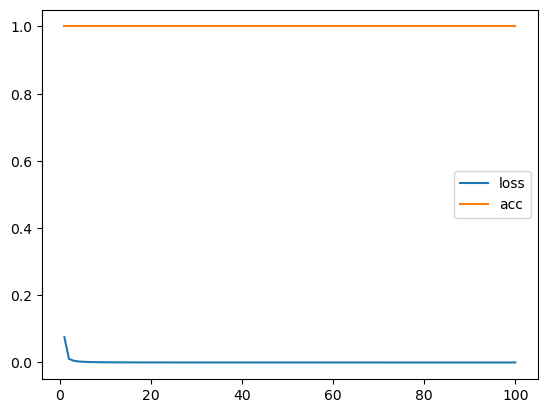

0.0754 0.0005 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000


In [19]:
import matplotlib.pyplot as plt
train_loss = np.load(os.path.join('..', 'models', 'finetune_3', 'tree_train_loss.npy'))
val_acc = np.load(os.path.join('..', 'models', 'finetune_3', 'tree_val_acc.npy'))
epochs = np.arange(1, train_loss.shape[0]+1)
plt.plot(epochs, train_loss, label='loss')
plt.plot(epochs, val_acc, label='acc')
plt.legend()
plt.show()
print(' '.join(f'{e:.4f}' for e in train_loss[::10]))
print(' '.join(f'{e:.4f}' for e in val_acc[::10]))